## Deep Learning Course Project - Gesture Recognition
---

#### Developed  solely by:
##### Abhishek Singh (aulakh.abhishek@gmail.com)

----


### Problem Statement
To develop a feature in the smart-TV to recognise five different gestures performed by the user which will help users control the TV without using a remote. Deep Learning models such as CONV3D and RNN will be used to train on set of videos of five type gestures where each vidoe contains a set of 30 time sequenced images.

The Five type of gestures are mentioned in the below table.
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

---


### Objectives:
- **Generator**:  Python generator function should be used to yeild the batch results and lables of time sequenced set of 30 images which represents the vidoe of a gesture type. 

- **Model**: Develop Deep Learning models with CONV3D and RNN which should be able to train without any errors and which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.
 

- Google COLAB Pro is used to train the models

In [ ]:
## Checking the GPU configuration

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 23 09:38:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Library Import

In [ ]:
# Importing the basic libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import datetime
import abc
from sys import getsizeof
import random as rn
import warnings
# Setting some defaults
% matplotlib inline
warnings.filterwarnings("ignore")

# Deep Learning library 
import tensorflow as tf
from tensorflow.keras import backend as K
# Keras API 
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
# Image processing
#from scipy.misc import imread, imresize # Depracted
from skimage.transform import resize
from imageio import imread
import cv2

Setting the random seed to keep the results repeatable.

In [ ]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

Mounting the dataset via Google Drive to Google Colab Pro

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/GestureRecognition/gestures_video_dataset/'
print(root_path)

Mounted at /content/gdrive
gdrive/My Drive/GestureRecognition/gestures_video_dataset/


Setting the path variables for Training & Validation CSV document for labels

In [ ]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/GestureRecognition/gestures_video_dataset/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/GestureRecognition/gestures_video_dataset/val.csv').readlines())

Defining a Plot to construct the charts of Loss & Accuracy between Training & Validation sets

In [ ]:
# function to plot the training/validation accuracies/losses.
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

## Generator
This is the most important part of the code which involves defining a `generator` function to yeild the batch results and labels.

We will use the Abstract Base Class feature of Python to construct a Master Class with all the basic initialisation required for our model building using CONV3D and RNN+CONV3D deep learning network. 

1. Setting up path for Images sequences & Labels
2. Default Image properties like Dimensions, Channels etc.
3. Initilising the the hyper parameters such as Number of Samples, Batch Size and Epochs
4. Generator function to yield the Image sequence and labels on request using next function
- The Generator function will take care of image resize and cropping followed by normalising them to same scale.No need for data augmentation as data size in five classes are balanced 
5. Finally the train_model method inside the class with take care of calls to generator function, Checkpoint calls to Keras for saving off the best models during training and the fit_generator function to fit the data. 


Let's create the masterclass as a wrapper to perform all basic functions in our machine learning model which are tunable with parameters

In [ ]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,root_path):
        self.train_doc = np.random.permutation(open(root_path + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(root_path + '/' + 'val.csv').readlines())
        self.train_path = root_path + '/' + 'train/'
        self.val_path =  root_path + '/' + 'val/'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_params(self,frames_to_sample=30,batch_size=32,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    #Generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.get_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 
            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.get_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
        
    def get_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):    
        seq_len = remaining_seq if remaining_seq else batch_size    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
      
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #image_resized=imresize(image,(self.image_height,self.image_width,3))
                image_resized=resize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))                   
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                                
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255                           
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
       
        return(batch_data,batch_labels)   
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch') # save_fre as preiod is deprecated
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)       
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Convolution Neural Networks 3D - CONV3D
- We will use the CONV3D model to take into account of the temporal dimension present in the set of images for each class. Similarly MaxPooling3D will use to pool across three dimension.
- A class inheriting from master Model Builder is defined to provide a skeletal CONV3D model with default parameters. The class will lay down the basic architecture as below 
- Keras Sequential [[CONV3D(16,32,64,128) -> Relu - > Batch Normalisation -> MaxPooling3D(2x2x2)]*4 -> Flatten -> [Dense(64) -> Batch Normalisation -> Dropout(.25)] -> Dense O/p (Softmax)]

**CONV3D - Sample model**

In [ ]:
class ModelConv3D1(ModelBuilder):
    def define_model(self):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam() #lr=0.001
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Instantiating the model from the ModelConv3D1() class and usting the methods to override the hyperparameters

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(root_path)
conv_3d1.initialize_image(image_height=120,image_width=120)
conv_3d1.initialize_params(frames_to_sample=30,batch_size=32,num_epochs=5)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_17 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 15, 60, 60, 32)   

- Cropping and plotting 2 random images form the dataset

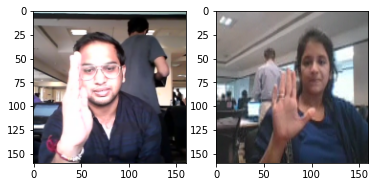

In [ ]:
# Test call to the generator function
test_generator=ModelConv3D1()
test_generator.initialize_path(root_path)
test_generator.initialize_image(image_height=160,image_width=160)
test_generator.initialize_params(frames_to_sample=30,batch_size=4,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

Ran a sample training of the model with only 5 epochs. The model ran fine with hyper parameters such as ReduceLROnPlateau kicked in.

In [ ]:
conv_3d1.train_model(conv_3d1_model)

Epoch 1/5
21/21 [==============================] - 5487s 273s/step - loss: 1.4680 - categorical_accuracy: 0.4449 - val_loss: 2.0696 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 2.06961, saving model to model_init_2021-10-2310_13_50.014898/model-00001-1.46800-0.44495-2.06961-0.16000.h5
Epoch 2/5
21/21 [==============================] - 207s 10s/step - loss: 1.0660 - categorical_accuracy: 0.6018 - val_loss: 3.5269 - val_categorical_accuracy: 0.1900

Epoch 00002: val_loss did not improve from 2.06961
Epoch 3/5
21/21 [==============================] - 214s 11s/step - loss: 0.7081 - categorical_accuracy: 0.7421 - val_loss: 4.5857 - val_categorical_accuracy: 0.1800

Epoch 00003: val_loss did not improve from 2.06961
Epoch 4/5
21/21 [==============================] - 196s 10s/step - loss: 0.5164 - categorical_accuracy: 0.8250 - val_loss: 5.0833 - val_categorical_accuracy: 0.1700

Epoch 00004: val_loss did not improve from 2.06961
Epoch 5/5
21/21 [============

Hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40.

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


- Based on some side experiments with the model, it was observed that below three are main hyper parameters which can be used to tune the model performance.
1. **"image resolution"** 
2. **number of frames**  
3. **batch_size** 
3. **epoch** 

- The Image resultion in the dataset is 160x120 and 120x120, We will try using different Image size in the model and observe the effect.
- Number of frames in sequence will define number of images chosen from the set of 30 for training, We will try values of 10,15,20 and 30
- We will start with Batch Size of 64 and later use 32, 16 and 8 


### Model #1

- Batch Size = 64
- Number of Frames = 10
- Epochs = 20
- Image Resolution = 120x120


In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        #model.add(Conv3D(128, filtersize, padding='same'))
        #model.add(Activation('relu'))
        #model.add(BatchNormalization())
        #model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam() #lr=0.001
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv3D_01=ModelConv3D1()
conv3D_01.initialize_path(root_path)
conv3D_01.initialize_image(image_height=120,image_width=120)
conv3D_01.initialize_params(frames_to_sample=10,batch_size=64,num_epochs=20)
conv3D_01_model=conv3D_01.define_model()
conv3D_01_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 10, 120, 120, 16)  1312      
_________________________________________________________________
activation_36 (Activation)   (None, 10, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 10, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 5, 60, 60, 16)     0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 5, 60, 60, 32)     13856     
_________________________________________________________________
activation_37 (Activation)   (None, 5, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 5, 60, 60, 32)   

In [ ]:
history_conv3D_01 = conv3D_01.train_model(conv3D_01_model)

Total Params: 997637
Epoch 1/20
11/11 [==============================] - 73s 7s/step - loss: 1.4320 - categorical_accuracy: 0.4691 - val_loss: 1.7111 - val_categorical_accuracy: 0.1800

Epoch 00001: val_loss improved from inf to 1.71110, saving model to model_init_2021-10-2312_26_25.740422/model-00001-1.43195-0.46908-1.71110-0.18000.h5
Epoch 2/20
11/11 [==============================] - 59s 6s/step - loss: 0.7930 - categorical_accuracy: 0.7119 - val_loss: 1.7199 - val_categorical_accuracy: 0.3400

Epoch 00002: val_loss did not improve from 1.71110
Epoch 3/20
11/11 [==============================] - 71s 7s/step - loss: 0.5089 - categorical_accuracy: 0.8130 - val_loss: 2.5862 - val_categorical_accuracy: 0.2300

Epoch 00003: val_loss did not improve from 1.71110
Epoch 4/20
11/11 [==============================] - 69s 7s/step - loss: 0.3636 - categorical_accuracy: 0.8854 - val_loss: 3.7263 - val_categorical_accuracy: 0.2400

Epoch 00004: val_loss did not improve from 1.71110
Epoch 5/20
11/

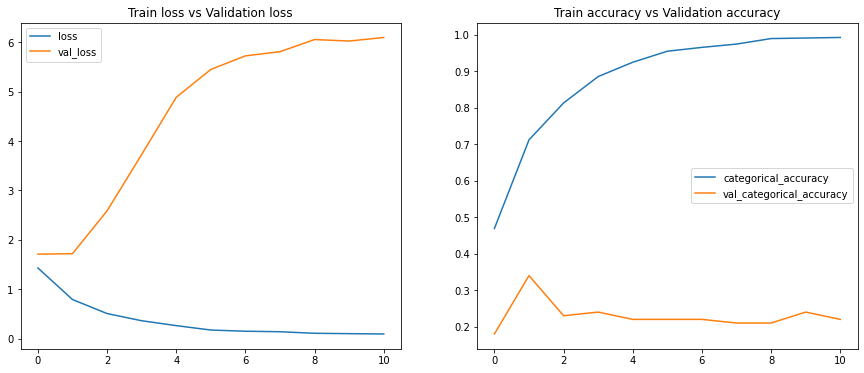

Max. Training Accuracy 0.9924585223197937
Max. Validaiton Accuracy 0.3400000035762787


In [ ]:
#plot(history_conv3D_01)
plotModelHistory(history_conv3D_01)

Model#1 is a highly Overfit model where the training accuracy reached close to 99% while the validation accuracy struggled at around 20%. Validation loss also kept on increasig during the model training and model itslef stopped the process.

|Model|Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|
| 1 | 64 | 10 | 120x120 | 20 |    997, 157 | .99 | .22 |6.095| Adam | Overfit

### Model #2  
- Batch Size = 32
- Number of Frames = 10
- Epochs = 20
- Image Resolution = 120x120

In [ ]:
conv3D_02=ModelConv3D1()
conv3D_02.initialize_path(root_path)
conv3D_02.initialize_image(image_height=120,image_width=120)
conv3D_02.initialize_params(frames_to_sample=10,batch_size=32,num_epochs=20)
conv3D_02_model=conv3D_02.define_model()
conv3D_02_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_42 (Conv3D)           (None, 10, 120, 120, 16)  1312      
_________________________________________________________________
activation_42 (Activation)   (None, 10, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 10, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_42 (MaxPooling (None, 5, 60, 60, 16)     0         
_________________________________________________________________
conv3d_43 (Conv3D)           (None, 5, 60, 60, 32)     13856     
_________________________________________________________________
activation_43 (Activation)   (None, 5, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 5, 60, 60, 32)   

In [ ]:
history_conv3D_02 = conv3D_02.train_model(conv3D_02_model)

Epoch 1/20
21/21 [==============================] - 68s 3s/step - loss: 1.5894 - categorical_accuracy: 0.4027 - val_loss: 1.5442 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 1.54416, saving model to model_init_2021-10-2312_53_05.609519/model-00001-1.58942-0.40271-1.54416-0.27000.h5
Epoch 2/20
21/21 [==============================] - 67s 3s/step - loss: 1.0077 - categorical_accuracy: 0.6078 - val_loss: 2.3310 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 1.54416
Epoch 3/20
21/21 [==============================] - 75s 4s/step - loss: 0.7207 - categorical_accuracy: 0.7406 - val_loss: 6.9513 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.54416
Epoch 4/20
21/21 [==============================] - 69s 3s/step - loss: 0.4932 - categorical_accuracy: 0.8311 - val_loss: 10.7605 - val_categorical_accuracy: 0.1800

Epoch 00004: val_loss did not improve from 1.54416
Epoch 5/20
21/21 [================

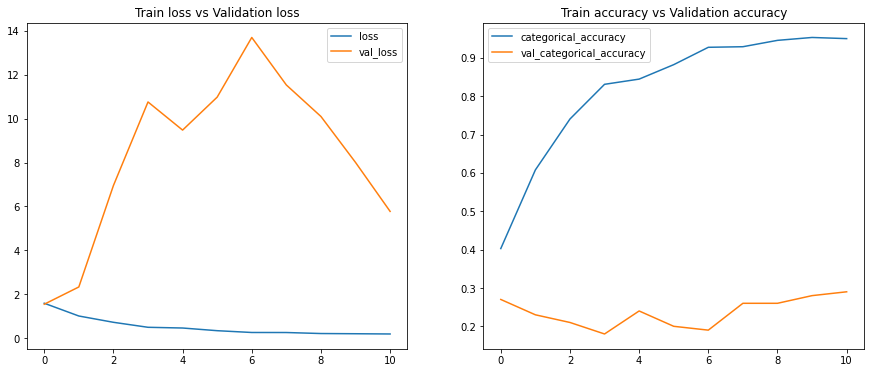

Max. Training Accuracy 0.953242838382721
Max. Validaiton Accuracy 0.28999999165534973


In [ ]:
plotModelHistory(history_conv3D_02)

Simailar to Model#1, This Model also did not performed well at all. The Validation accuracy is poor and there it is an Overfit model. Validation Loss also never really improved and the model itself stopped the training after 11th epoch

|Model|Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|
| 2 | 32 | 10 | 120x120 | 20 |    997, 157 | .95 | .29 | 5.77 |Adam | Overfit


##### Write the details here 


### Model #3 
- Batch Size = 16
- Number of Frames = 15
- Epochs = 20
- Image Resolution = 120x120


In [ ]:
conv3D_03=ModelConv3D1()
conv3D_03.initialize_path(root_path)
conv3D_03.initialize_image(image_height=120,image_width=120)
conv3D_03.initialize_params(frames_to_sample=15,batch_size=16,num_epochs=20)
conv3D_03_model=conv3D_03.define_model()
conv3D_03_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_48 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_48 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_74 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_48 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_49 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_75 (Batc (None, 7, 60, 60, 32)   

In [ ]:
history_conv3D_03 = conv3D_03.train_model(conv3D_03_model)

Epoch 1/20
42/42 [==============================] - 108s 3s/step - loss: 1.5524 - categorical_accuracy: 0.3937 - val_loss: 1.8777 - val_categorical_accuracy: 0.3000

Epoch 00001: val_loss improved from inf to 1.87768, saving model to model_init_2021-10-2313_17_49.984588/model-00001-1.55242-0.39367-1.87768-0.30000.h5
Epoch 2/20
42/42 [==============================] - 100s 2s/step - loss: 0.9393 - categorical_accuracy: 0.6275 - val_loss: 5.6964 - val_categorical_accuracy: 0.1700

Epoch 00002: val_loss did not improve from 1.87768
Epoch 3/20
42/42 [==============================] - 107s 3s/step - loss: 0.7033 - categorical_accuracy: 0.7285 - val_loss: 5.5729 - val_categorical_accuracy: 0.2200

Epoch 00003: val_loss did not improve from 1.87768
Epoch 4/20
42/42 [==============================] - 109s 3s/step - loss: 0.6552 - categorical_accuracy: 0.7647 - val_loss: 5.7782 - val_categorical_accuracy: 0.2200

Epoch 00004: val_loss did not improve from 1.87768
Epoch 5/20
42/42 [=============

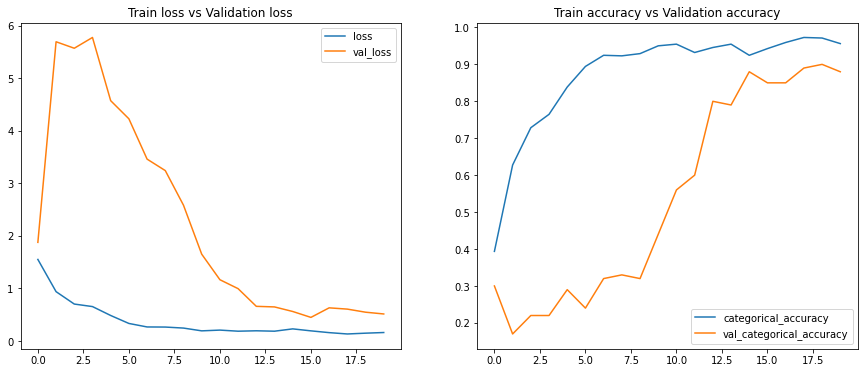

Max. Training Accuracy 0.9728506803512573
Max. Validaiton Accuracy 0.8999999761581421


In [ ]:
plotModelHistory(history_conv3D_03)

Model #3 is a very good fit model. 
- Training Accuracy improved during the training and reach around 95%
- Validation Accuracy picked up after epoch 10 and was around 90% after the end of training 
- Training & Validation loss kept on reducing through out. 


|Model|Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|
| 3 | 16 | 15 | 120x120 | 20 |    997, 157 | .95 | .88 | 0.51 |Adam | Good fit

### Model #4
- Batch Size = 16
- Number of Frames = 20
- Epochs = 30
- Image Resolution = 100x100

In [ ]:
conv3D_04=ModelConv3D1()
conv3D_04.initialize_path(root_path)
conv3D_04.initialize_image(image_height=100,image_width=100)
conv3D_04.initialize_params(frames_to_sample=20,batch_size=16,num_epochs=30)
conv3D_04_model=conv3D_04.define_model()
conv3D_04_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_51 (Conv3D)           (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
activation_51 (Activation)   (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_51 (MaxPooling (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_52 (Conv3D)           (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
activation_52 (Activation)   (None, 10, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_80 (Batc (None, 10, 50, 50, 32)  

In [ ]:
history_conv3D_04 = conv3D_04.train_model(conv3D_04_model)

Epoch 1/30
42/42 [==============================] - 140s 3s/step - loss: 1.6126 - categorical_accuracy: 0.3861 - val_loss: 2.2533 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 2.25333, saving model to model_init_2021-10-2313_58_51.803262/model-00001-1.61260-0.38612-2.25333-0.21000.h5
Epoch 2/30
42/42 [==============================] - 138s 3s/step - loss: 1.0238 - categorical_accuracy: 0.6169 - val_loss: 9.2102 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 2.25333
Epoch 3/30
42/42 [==============================] - 143s 3s/step - loss: 0.7535 - categorical_accuracy: 0.7179 - val_loss: 12.3515 - val_categorical_accuracy: 0.1900

Epoch 00003: val_loss did not improve from 2.25333
Epoch 4/30
42/42 [==============================] - 135s 3s/step - loss: 0.6375 - categorical_accuracy: 0.7526 - val_loss: 10.2450 - val_categorical_accuracy: 0.2800

Epoch 00004: val_loss did not improve from 2.25333
Epoch 5/30
42/42 [===========

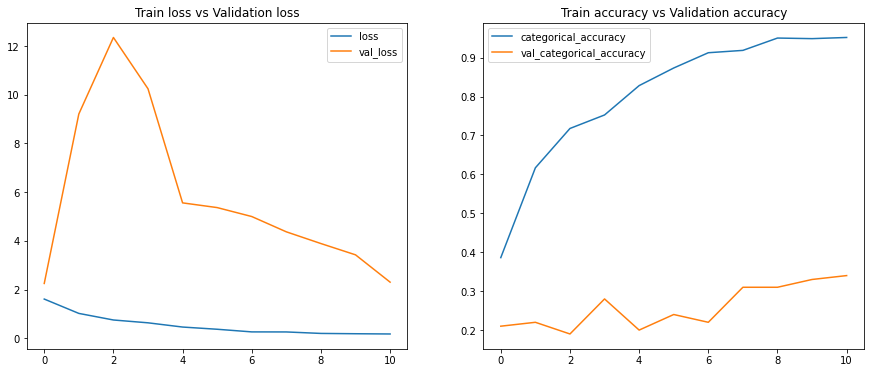

Max. Training Accuracy 0.9517345428466797
Max. Validaiton Accuracy 0.3400000035762787


In [ ]:
plotModelHistory(history_conv3D_04)

Model #4 turned out to be a bad and a Overfit model. 
- Training Accuracy improved during the training and reach around 95%
- Validation Accuracy struggled to reach even to levels of 30% 
- Validation Loss remained high after the end of the training


|Model|Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|
| 4 | 16 | 20 | 100x100 | 30 | 1, 255, 205 | .95 | .34 | 2.30 |Adam | Overfit

### Model #5
- Batch Size = 16
- Number of Frames = 20
- Epochs = 30
- Image Resolution = 120x120
- Dense Layer with 256 nuerons and Dropout = 0.5 
- Filter Size = 2x2

In [ ]:
conv3D_05=ModelConv3D1()
conv3D_05.initialize_path(root_path)
conv3D_05.initialize_image(image_height=120,image_width=120)
conv3D_05.initialize_params(frames_to_sample=20,batch_size=16,num_epochs=30)
conv3D_05_model=conv3D_05.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv3D_05_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_57 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_89 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_57 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_58 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 10, 60, 60, 32)  

In [ ]:
history_conv3D_05 = conv3D_05.train_model(conv3D_05_model)

Epoch 1/30
42/42 [==============================] - 138s 3s/step - loss: 1.6694 - categorical_accuracy: 0.4646 - val_loss: 3.2907 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 3.29069, saving model to model_init_2021-10-2314_35_59.827089/model-00001-1.66943-0.46456-3.29069-0.16000.h5
Epoch 2/30
42/42 [==============================] - 127s 3s/step - loss: 0.9010 - categorical_accuracy: 0.6546 - val_loss: 5.8483 - val_categorical_accuracy: 0.1500

Epoch 00002: val_loss did not improve from 3.29069
Epoch 3/30
42/42 [==============================] - 140s 3s/step - loss: 0.6801 - categorical_accuracy: 0.7421 - val_loss: 8.4185 - val_categorical_accuracy: 0.1500

Epoch 00003: val_loss did not improve from 3.29069
Epoch 4/30
42/42 [==============================] - 130s 3s/step - loss: 0.4725 - categorical_accuracy: 0.8431 - val_loss: 8.2125 - val_categorical_accuracy: 0.1100

Epoch 00004: val_loss did not improve from 3.29069
Epoch 5/30
42/42 [=============

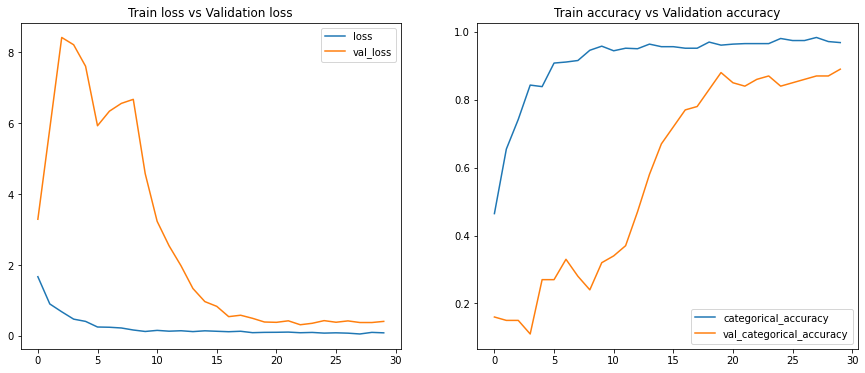

Max. Training Accuracy 0.9834087491035461
Max. Validaiton Accuracy 0.8899999856948853


In [ ]:
plotModelHistory(history_conv3D_05)

This model performed very well. 
- The Training Accuracy kept on inceasing and reached the levels of 96%
- The Validation Accuracy also followed increasing trend and reached at around 89%
- The Validation Loss increased initially but later on fell to with acceptable limits
- Overall a good fit model

|Model|Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc|Var Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|
| 5 | 16 | 20 | 120x120 | 30 | 7, 462, 357 | .96 | .89 | 1.337 |Adam | Good Fit/High Training time

### Model #6
- Batch Size = 32
- Number of Frames = 15
- Epochs = 30
- Image Resolution = 80x80
- Dense Layer with 512 nuerons and Dropout = 0.5 
- Filter Size = 3x3

In [ ]:
conv3D_06=ModelConv3D1()
conv3D_06.initialize_path(root_path)
conv3D_06.initialize_image(image_height=80,image_width=80)
conv3D_06.initialize_params(frames_to_sample=15,batch_size=32,num_epochs=30)
conv3D_06_model=conv3D_06.define_model(filtersize=(3,3,3),dense_neurons=512,dropout=0.5)
conv3D_06_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_60 (Conv3D)           (None, 15, 80, 80, 16)    1312      
_________________________________________________________________
activation_60 (Activation)   (None, 15, 80, 80, 16)    0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 15, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_60 (MaxPooling (None, 7, 40, 40, 16)     0         
_________________________________________________________________
conv3d_61 (Conv3D)           (None, 7, 40, 40, 32)     13856     
_________________________________________________________________
activation_61 (Activation)   (None, 7, 40, 40, 32)     0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 7, 40, 40, 32)   

In [ ]:
history_conv3D_06 = conv3D_06.train_model(conv3D_06_model)

Epoch 1/30
21/21 [==============================] - 102s 5s/step - loss: 1.7563 - categorical_accuracy: 0.4510 - val_loss: 2.4103 - val_categorical_accuracy: 0.1700

Epoch 00001: val_loss improved from inf to 2.41029, saving model to model_init_2021-10-2315_51_41.989827/model-00001-1.75635-0.45098-2.41029-0.17000.h5
Epoch 2/30
21/21 [==============================] - 108s 5s/step - loss: 1.0154 - categorical_accuracy: 0.6606 - val_loss: 5.4777 - val_categorical_accuracy: 0.1800

Epoch 00002: val_loss did not improve from 2.41029
Epoch 3/30
21/21 [==============================] - 104s 5s/step - loss: 0.6107 - categorical_accuracy: 0.7617 - val_loss: 9.3343 - val_categorical_accuracy: 0.1200

Epoch 00003: val_loss did not improve from 2.41029
Epoch 4/30
21/21 [==============================] - 104s 5s/step - loss: 0.3499 - categorical_accuracy: 0.8582 - val_loss: 8.9230 - val_categorical_accuracy: 0.1500

Epoch 00004: val_loss did not improve from 2.41029
Epoch 5/30
21/21 [=============

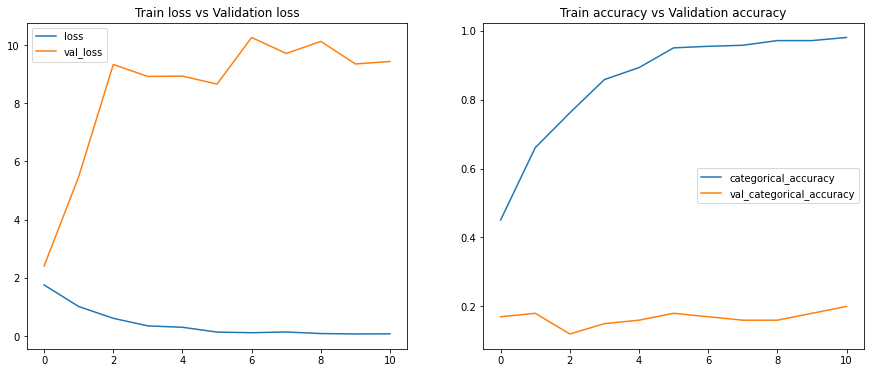

Max. Training Accuracy 0.9803921580314636
Max. Validaiton Accuracy 0.20000000298023224


In [ ]:
plotModelHistory(history_conv3D_06)

Image size was reduced to 80x80 and Dense layers nuerons were set at 512 along with Droput rate of 50%.The trainable paramters were high therefore. The Result was that the model performed poorly haveing very Low Variance
- The Validation Accuracy never really kicked off 
- The Validation Loss was always on the rise and therefore the model stopped it self after 11 epochs

|Model|Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|
| 6 | 32 | 15 |   80x80 | 30 | 3, 615, 333 | .98 | .20 |9.43 | Adam | Poor Model

### Model #7
- Batch Size = 8
- Number of Frames = 30
- Epochs = 30
- Image Resolution = 120x120
- Dense Layer with 128 nuerons and Dropout = 0.25 
- Filter Size = 3x3
- Optimiser = Stochastic Gradient Descent

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = tf.keras.optimizers.Adam() #lr=0.001
        optimiser = "sgd"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv3D_07=ModelConv3D1()
conv3D_07.initialize_path(root_path)
conv3D_07.initialize_image(image_height=120,image_width=120)
conv3D_07.initialize_params(frames_to_sample=10,batch_size=8,num_epochs=30)
conv3D_07_model=conv3D_07.define_model(filtersize=(3,3,3),dense_neurons=128,dropout=0.25)
conv3D_07_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 10, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 5, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 60, 60, 32)     1

In [ ]:
history_conv3D_07 = conv3D_07.train_model(conv3D_07_model)

Epoch 1/30
83/83 [==============================] - 1721s 21s/step - loss: 1.6525 - categorical_accuracy: 0.4103 - val_loss: 1.8317 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 1.83166, saving model to model_init_2021-10-2318_48_50.159355/model-00001-1.65253-0.41026-1.83166-0.27000.h5
Epoch 2/30
83/83 [==============================] - 90s 1s/step - loss: 1.3149 - categorical_accuracy: 0.4902 - val_loss: 1.9542 - val_categorical_accuracy: 0.2800

Epoch 00002: val_loss did not improve from 1.83166
Epoch 3/30
83/83 [==============================] - 86s 1s/step - loss: 1.1221 - categorical_accuracy: 0.5973 - val_loss: 2.0581 - val_categorical_accuracy: 0.3000

Epoch 00003: val_loss did not improve from 1.83166
Epoch 4/30
83/83 [==============================] - 84s 1s/step - loss: 0.8247 - categorical_accuracy: 0.6833 - val_loss: 2.4026 - val_categorical_accuracy: 0.2600

Epoch 00004: val_loss did not improve from 1.83166
Epoch 5/30
83/83 [==============

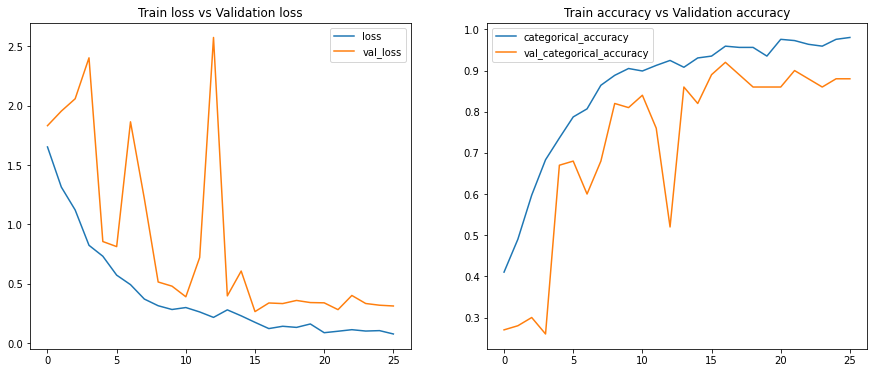

Max. Training Accuracy 0.9803921580314636
Max. Validaiton Accuracy 0.9200000166893005


In [ ]:
plotModelHistory(history_conv3D_07)

This model was built with reduced Batch size of 8 and Optimiser as 'SGD' instead of Adam. 
-The model is a very good fit with High Accuracy values for Training & Validation
- In terms of Losss, both training and validation loss reduced through out. 
- A very good fit but with increased parameters.

|Model|Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|
| 7 |  8 | 10 | 120x120 | 30 | 1, 931, 749 | .98 | .88 | .60 | SGD  | Very Good Fit

### Model #8
- Batch Size = 8
- Number of Frames = 10
- Epochs = 30
- Image Resolution = 120x120
- Dense Layer with 64 nuerons and Dropout = 0.25 
- Filter Size = 3x3

In [ ]:

class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3)):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(.5))

        model.add(Dense(32,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = tf.keras.optimizers.Adam() #lr=0.001
        optimiser = "sgd"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model



In [ ]:
conv3D_08=ModelConv3D1()
conv3D_08.initialize_path(root_path)
conv3D_08.initialize_image(image_height=120,image_width=120)
conv3D_08.initialize_params(frames_to_sample=10,batch_size=8,num_epochs=30)
conv3D_08_model=conv3D_08.define_model()
conv3D_08_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 10, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 5, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 60, 60, 32)     1

In [ ]:
history_conv3D_08 = conv3D_08.train_model(conv3D_08_model)

Epoch 1/30
83/83 [==============================] - 2544s 31s/step - loss: 1.8308 - categorical_accuracy: 0.2986 - val_loss: 13.1847 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 13.18475, saving model to model_init_2021-10-2404_11_44.331735/model-00001-1.83080-0.29864-13.18475-0.23000.h5
Epoch 2/30
83/83 [==============================] - 69s 845ms/step - loss: 1.5937 - categorical_accuracy: 0.3635 - val_loss: 1.7741 - val_categorical_accuracy: 0.3500

Epoch 00002: val_loss improved from 13.18475 to 1.77414, saving model to model_init_2021-10-2404_11_44.331735/model-00002-1.59374-0.36350-1.77414-0.35000.h5
Epoch 3/30
83/83 [==============================] - 64s 784ms/step - loss: 1.5239 - categorical_accuracy: 0.3846 - val_loss: 1.6070 - val_categorical_accuracy: 0.3900

Epoch 00003: val_loss improved from 1.77414 to 1.60698, saving model to model_init_2021-10-2404_11_44.331735/model-00003-1.52390-0.38462-1.60698-0.39000.h5
Epoch 4/30
83/83 [==========

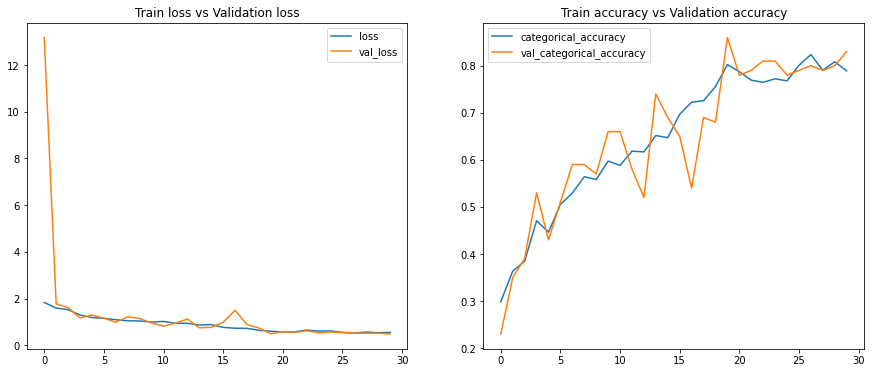

Max. Training Accuracy 0.8235294222831726
Max. Validaiton Accuracy 0.8600000143051147


In [ ]:
plotModelHistory(history_conv3D_08)

Batch size of 8 and Optimiser as 'SGD' was kept from Model#8, but the trainable parameters were reduced by keeping Dense neurons at 64
-The model improved further from previous model with High Accuracy values for Training & Validation
- In terms of Losss, both training and validation loss reduced through out to significantly low values. 
- A very good fit model. 

|Model|Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|
| 8 |  8 | 10 | 120x120 | 30 |    994, 853 | .78 | .83 | .76|SGD  | Very Good Fit

### Model #9 

Final CONV3D model with Reduced Parameter

Model #3 performed best in terms of fitting the data with least number of trainable parameters and good accuracy on training & validation set. 

- Batch Size = 16
- Number of Frames = 15
- Epochs = 30
- Image Resolution = 120x120
- 2 Dense Layer with 64 & 32 nuerons and Dropout = 0.5 
- Filter Size = 3x3

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3)):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(.5))

        model.add(Dense(32,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam() #lr=0.001
        #optimiser = "sgd"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model



In [ ]:
conv3D_09_final=ModelConv3D1()
conv3D_09_final.initialize_path(root_path)
conv3D_09_final.initialize_image(image_height=120,image_width=120)
conv3D_09_final.initialize_params(frames_to_sample=15,batch_size=16,num_epochs=30)
conv3D_09_final_model=conv3D_09_final.define_model()
conv3D_09_final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_3 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_4 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 60, 60, 32)    

In [ ]:
curr_dt_time = datetime.datetime.now()
history_conv3D_09_final = conv3D_09_final.train_model(conv3D_09_final_model)
curr_dt_time = datetime.datetime.now()

Epoch 1/30
42/42 [==============================] - 133s 3s/step - loss: 1.9801 - categorical_accuracy: 0.3002 - val_loss: 2.9554 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 2.95539, saving model to model_init_2021-10-2410_03_35.941389/model-00001-1.98012-0.30015-2.95539-0.21000.h5
Epoch 2/30
42/42 [==============================] - 130s 3s/step - loss: 1.4291 - categorical_accuracy: 0.4480 - val_loss: 2.7767 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss improved from 2.95539 to 2.77673, saving model to model_init_2021-10-2410_03_35.941389/model-00002-1.42908-0.44796-2.77673-0.22000.h5
Epoch 3/30
42/42 [==============================] - 135s 3s/step - loss: 1.1890 - categorical_accuracy: 0.5234 - val_loss: 3.4232 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 2.77673
Epoch 4/30
42/42 [==============================] - 130s 3s/step - loss: 0.9312 - categorical_accuracy: 0.6275 - val_loss: 3.6342 - val_categor

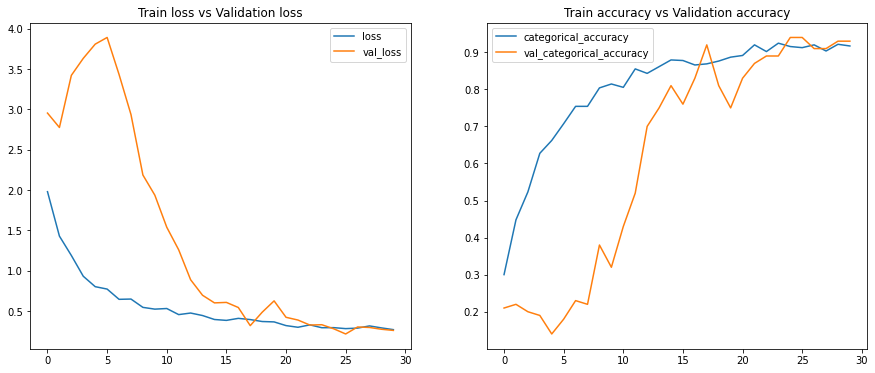

Max. Training Accuracy 0.924585223197937
Max. Validaiton Accuracy 0.9399999976158142


In [ ]:
plotModelHistory(history_conv3D_09_final)

This Final version of the model was built with Batch size of 16, Number of frames to 15 and Optimiser as 'Adam'. The trainable parameters were reduced by keeping Dense neurons at 64
-The model was trained High Accuracy values for Training & Validation showing good robustness
- In terms of Losss, both training and validation loss reduced through out to significantly low values. 
- A very good fit model. 

|Model|Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|
| Final | 16 | 15 | 120x120 | 30 |    994, 853 | .82 | .88 |.69 |Adam | Good Fit/Reduced params

### Summary of Models built using CONV3D models

|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 1 | CONV3D |64 | 10 | 120x120 | 20 |    997, 157 | .99 | .22 |6.095| Adam | Overfit
| 2 | CONV3D|32 | 10 | 120x120 | 20 |    997, 157 | .95 | .29 | 5.77 |Adam | Overfit
| 3 | CONV3D|16 | 15 | 120x120 | 20 |    997, 157 | .95 | .88 | 0.51 |Adam | Good fit
| 4 | CONV3D|16 | 20 | 100x100 | 30 | 1, 255, 205 | .95 | .34 | 2.30 |Adam | Overfit
| 5 | CONV3D|16 | 20 | 120x120 | 30 | 7, 462, 357 | .96 | .89 | 1.337 |Adam | Very Good Fit/High Training time
| 6 | CONV3D|32 | 15 |   80x80 | 30 | 3, 615, 333 | .98 | .20 |9.43 | Adam | Worst Model
| 7 | CONV3D |8 | 10 | 120x120 | 30 | 1, 931, 749 | .98 | .88 | .60 | SGD  | Very Good Fit
| 8 | CONV3D |8 | 10 | 120x120 | 30 |    994, 853 | .78 | .83 | .76|SGD  | Good Fit
| Final |CONV3D |16 | 15 | 120x120 | 30 |    994, 853 | .82 | .88 |.69 |Adam | Good Fit/Reduced params

## Recurrent Neural Network + Convolutional Neural Network
RNN - > CNN (2D) - > Softmax Dense

## LSTM ( Long Short Term Memory) 


### Model #1

- LSTM Cells = 128
- Time Distributed Layers wrapped CONV2D layers with ReLU activation
- Batch Size - 64
- Num of Samples = 15
- Image size = 120x120
- Optimiser = Adam
- Epochs = 20

In [ ]:
class RNN_CNN2D_LSTM(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
        #model.add(TimeDistributed(BatchNormalization()))
        #model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam() #lr=0.001
        #optimiser = "sgd"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2d_01=RNN_CNN2D_LSTM()
rnn_cnn2d_01.initialize_path(root_path)
rnn_cnn2d_01.initialize_image(image_height=120,image_width=120)
rnn_cnn2d_01.initialize_params(frames_to_sample=15,batch_size=64,num_epochs=20)
rnn_cnn2d_01_model=rnn_cnn2d_01.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2d_01_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_48 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_49 (TimeDis (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_50 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_52 (TimeDis (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_53 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 15, 30, 30, 64)   

In [ ]:
history_rnn_cnn2d_01_model=rnn_cnn2d_01.train_model(rnn_cnn2d_01_model,augment_data=False)

Epoch 1/20
11/11 [==============================] - 142s 14s/step - loss: 1.4587 - categorical_accuracy: 0.3710 - val_loss: 1.6150 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 1.61498, saving model to model_init_2021-10-2411_44_52.022498/model-00001-1.45875-0.37104-1.61498-0.16000.h5
Epoch 2/20
11/11 [==============================] - 135s 13s/step - loss: 1.0545 - categorical_accuracy: 0.5928 - val_loss: 1.7572 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 1.61498
Epoch 3/20
11/11 [==============================] - 137s 14s/step - loss: 0.8723 - categorical_accuracy: 0.6772 - val_loss: 1.9139 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 1.61498
Epoch 4/20
11/11 [==============================] - 143s 14s/step - loss: 0.6559 - categorical_accuracy: 0.7481 - val_loss: 1.9758 - val_categorical_accuracy: 0.2600

Epoch 00004: val_loss did not improve from 1.61498
Epoch 5/20
11/11 [=========

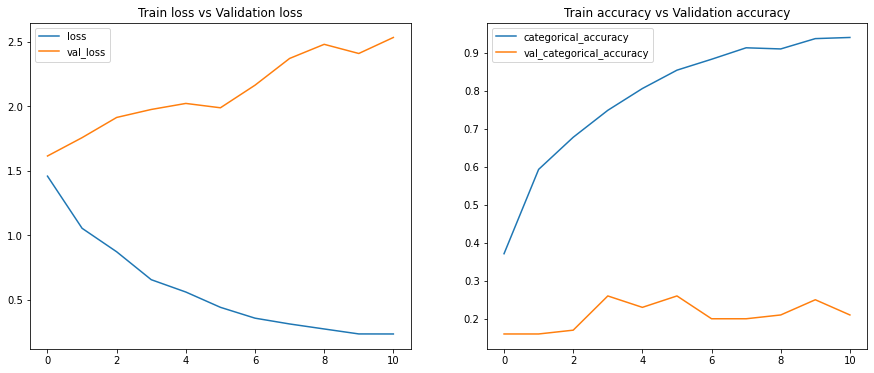

Max. Training Accuracy 0.9396681785583496
Max. Validaiton Accuracy 0.25999999046325684


In [ ]:
plotModelHistory(history_rnn_cnn2d_01_model)

CONV2D + LSTM model with 128 cells was picked as first option with Batch size of 64 and Sample size of 15. 

- Model is not a good fit as it performed poorly on Validation set. The Validation loss always increased and Validation accuracy never increased beyond 25%

|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 1 | LSTM|64 | 15 | 120x120 | 20 |    1, 656, 453 | .93 | .21 | 2.53| Adam | Overfit


### Model #2

- LSTM Cells = 128
- Time Distributed Layers wrapped CONV2D layers with ReLU activation
- Batch Size - 32
- Num of Samples = 20
- Image size = 120x120
- Optimiser = Adam
- Epochs = 30

In [ ]:
rnn_cnn2d_02=RNN_CNN2D_LSTM()
rnn_cnn2d_02.initialize_path(root_path)
rnn_cnn2d_02.initialize_image(image_height=120,image_width=120)
rnn_cnn2d_02.initialize_params(frames_to_sample=15,batch_size=32,num_epochs=30)
rnn_cnn2d_02_model=rnn_cnn2d_02.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2d_02_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_112 (TimeDi (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_113 (TimeDi (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_114 (TimeDi (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_115 (TimeDi (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_116 (TimeDi (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_117 (TimeDi (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_118 (TimeDi (None, 15, 30, 30, 64)   

In [ ]:
history_rnn_cnn2d_02_model=rnn_cnn2d_02.train_model(rnn_cnn2d_02_model,augment_data=False)

Epoch 1/30
21/21 [==============================] - 134s 6s/step - loss: 1.3990 - categorical_accuracy: 0.3967 - val_loss: 1.6925 - val_categorical_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 1.69254, saving model to model_init_2021-10-2412_41_01.200483/model-00001-1.39899-0.39668-1.69254-0.25000.h5
Epoch 2/30
21/21 [==============================] - 130s 6s/step - loss: 1.0844 - categorical_accuracy: 0.5732 - val_loss: 1.5935 - val_categorical_accuracy: 0.2900

Epoch 00002: val_loss improved from 1.69254 to 1.59345, saving model to model_init_2021-10-2412_41_01.200483/model-00002-1.08438-0.57315-1.59345-0.29000.h5
Epoch 3/30
21/21 [==============================] - 132s 7s/step - loss: 0.8766 - categorical_accuracy: 0.6531 - val_loss: 2.0290 - val_categorical_accuracy: 0.1300

Epoch 00003: val_loss did not improve from 1.59345
Epoch 4/30
21/21 [==============================] - 126s 6s/step - loss: 0.6775 - categorical_accuracy: 0.7436 - val_loss: 1.8906 - val_categor

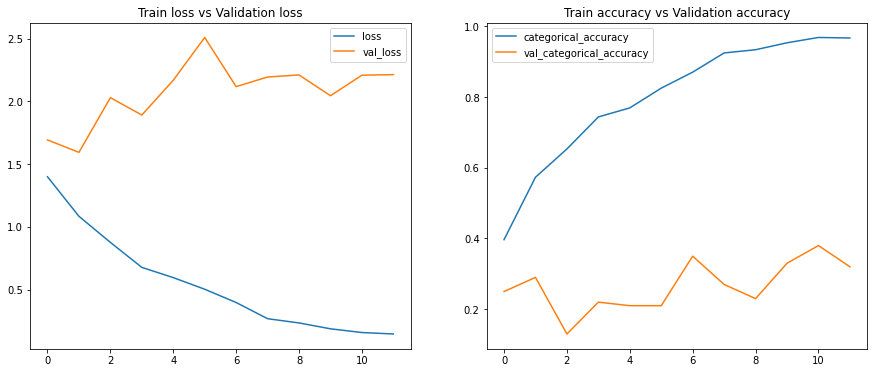

Max. Training Accuracy 0.9683257937431335
Max. Validaiton Accuracy 0.3799999952316284


In [ ]:
plotModelHistory(history_rnn_cnn2d_02_model)

The Batch size was reduced to 32 while remaining all other parameters same as with first model.
Model performed poorly again with sligh improvement in the training accuracy and validation loss. Overall a bad fit 

|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 2 | LSTM|32 | 15 | 120x120 | 30 |    1, 656, 453 | .96 | .32 | 2.21| Adam | Overfit


### Model #3

- LSTM Cells = 128
- Time Distributed Layers wrapped CONV2D layers with ReLU activation
- Batch Size - 16
- Num of Samples = 15
- Image size = 100x100
- Optimiser = Adam
- Epochs = 30

In [ ]:
rnn_cnn2d_03=RNN_CNN2D_LSTM()
rnn_cnn2d_03.initialize_path(root_path)
rnn_cnn2d_03.initialize_image(image_height=100,image_width=100)
rnn_cnn2d_03.initialize_params(frames_to_sample=15,batch_size=16,num_epochs=30)
rnn_cnn2d_03_model=rnn_cnn2d_03.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2d_03_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 25, 25, 64)    1

In [ ]:
history_rnn_cnn2d_03_model=rnn_cnn2d_03.train_model(rnn_cnn2d_03_model,augment_data=False)

Epoch 1/30
42/42 [==============================] - 3664s 89s/step - loss: 1.4098 - categorical_accuracy: 0.3786 - val_loss: 1.6774 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 1.67736, saving model to model_init_2021-10-2503_12_52.593524/model-00001-1.40984-0.37858-1.67736-0.21000.h5
Epoch 2/30
42/42 [==============================] - 106s 3s/step - loss: 1.1011 - categorical_accuracy: 0.5641 - val_loss: 2.3672 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 1.67736
Epoch 3/30
42/42 [==============================] - 107s 3s/step - loss: 0.9364 - categorical_accuracy: 0.6531 - val_loss: 2.0988 - val_categorical_accuracy: 0.3000

Epoch 00003: val_loss did not improve from 1.67736
Epoch 4/30
42/42 [==============================] - 97s 2s/step - loss: 0.7565 - categorical_accuracy: 0.7300 - val_loss: 2.1282 - val_categorical_accuracy: 0.2000

Epoch 00004: val_loss did not improve from 1.67736
Epoch 5/30
42/42 [============

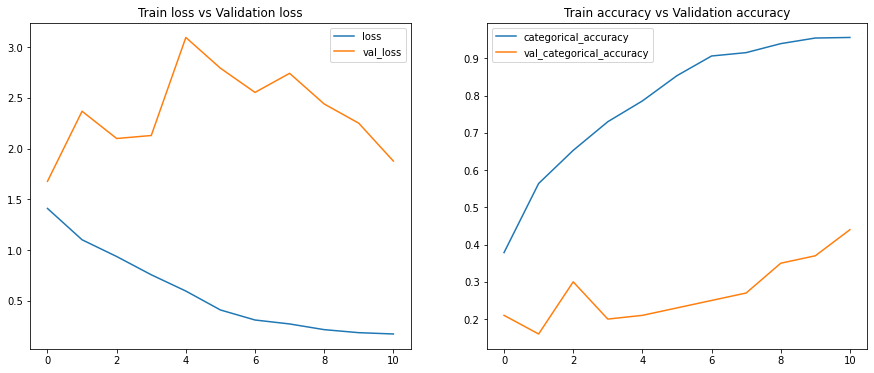

Max. Training Accuracy 0.9562594294548035
Max. Validaiton Accuracy 0.4399999976158142


In [ ]:
plotModelHistory(history_rnn_cnn2d_03_model)

Batch size was further reduced to 16 with number of frames still same as 15 and Image resolution as 120x120. 

We can notice again a slight improvement in the training accuracy and validation loss, This shows that reducing the batch size is improving the training.
The model though is still Overfit

|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 3 | LSTM|16 | 15 | 100x100 | 30 | 1, 656, 453 | .95 | .44 | 1.87 | Adam | Overfit

### Model #4

- LSTM Cells = 128
- Time Distributed Layers wrapped CONV2D layers with ReLU activation
- Batch Size - 16
- Num of Samples = 10
- Image size = 100x100
- Optimiser = Adam
- Epochs = 30
- LSTM Cells = 64
- Dense Layer Dropouts = 0.5



In [ ]:
rnn_cnn2d_04=RNN_CNN2D_LSTM()
rnn_cnn2d_04.initialize_path(root_path)
rnn_cnn2d_04.initialize_image(image_height=100,image_width=100)
rnn_cnn2d_04.initialize_params(frames_to_sample=10,batch_size=16,num_epochs=30)
rnn_cnn2d_04_model=rnn_cnn2d_04.define_model(lstm_cells=64,dense_neurons=128,dropout=0.5)
rnn_cnn2d_04_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_64 (TimeDis (None, 10, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_65 (TimeDis (None, 10, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_66 (TimeDis (None, 10, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_67 (TimeDis (None, 10, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_68 (TimeDis (None, 10, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_69 (TimeDis (None, 10, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_70 (TimeDis (None, 10, 25, 25, 64)   

In [ ]:
history_rnn_cnn2d_04_model=rnn_cnn2d_04.train_model(rnn_cnn2d_04_model,augment_data=False)

Epoch 1/30
42/42 [==============================] - 73s 2s/step - loss: 1.6149 - categorical_accuracy: 0.2670 - val_loss: 1.6918 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 1.69178, saving model to model_init_2021-10-2505_11_39.733548/model-00001-1.61494-0.26697-1.69178-0.16000.h5
Epoch 2/30
42/42 [==============================] - 68s 2s/step - loss: 1.4526 - categorical_accuracy: 0.3771 - val_loss: 1.9118 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 1.69178
Epoch 3/30
42/42 [==============================] - 67s 2s/step - loss: 1.3461 - categorical_accuracy: 0.4087 - val_loss: 1.6959 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.69178
Epoch 4/30
42/42 [==============================] - 68s 2s/step - loss: 1.2029 - categorical_accuracy: 0.5008 - val_loss: 1.8178 - val_categorical_accuracy: 0.3200

Epoch 00004: val_loss did not improve from 1.69178
Epoch 5/30
42/42 [=================

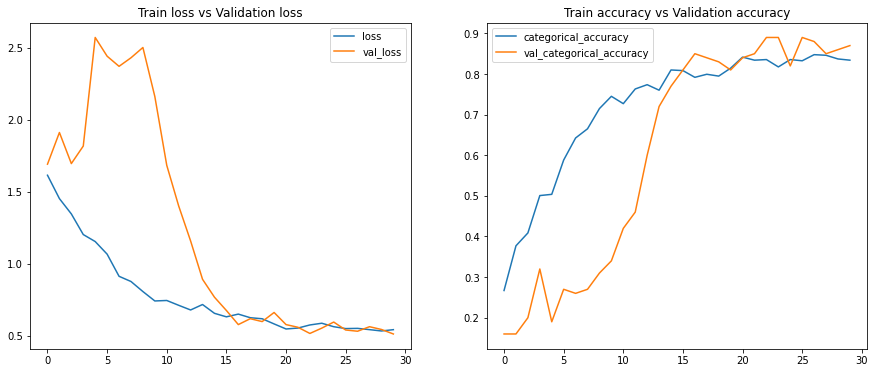

Max. Training Accuracy 0.8476621508598328
Max. Validaiton Accuracy 0.8899999856948853


In [ ]:
plotModelHistory(history_rnn_cnn2d_04_model)

The batch size was kept at 16 but number of samples were reduced to 10. The training & validation accuracy further improved. The model came up with accuracies in the range of 80%-90%. 

Training accuracy = 83% , Validation Accuracy = 87%

Model is Good fit with low Variance


|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 4 |LSTM |16 | 10 | 100x100 | 30 |    1, 009, 029 | .83 | .87 | .51 | Adam | Good fit

### Model #5

-- Reducued Parameters

- Time Distributed Layers wrapped CONV2D layers with ReLU activation
- Batch Size - 16
- Num of Samples = 10
- Image size = 120x120
- Optimiser = Adam
- Epochs = 30
- LSTM Cells = 64
- Dense Layer = 64
- Dropouts = 0.5



In [ ]:
rnn_cnn2d_05=RNN_CNN2D_LSTM()
rnn_cnn2d_05.initialize_path(root_path)
rnn_cnn2d_05.initialize_image(image_height=100,image_width=100)
rnn_cnn2d_05.initialize_params(frames_to_sample=10,batch_size=32,num_epochs=30)
rnn_cnn2d_05_model=rnn_cnn2d_05.define_model(lstm_cells=64,dense_neurons=64,dropout=0.5)
rnn_cnn2d_05_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_144 (TimeDi (None, 10, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_145 (TimeDi (None, 10, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_146 (TimeDi (None, 10, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_147 (TimeDi (None, 10, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_148 (TimeDi (None, 10, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_149 (TimeDi (None, 10, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_150 (TimeDi (None, 10, 25, 25, 64)   

In [ ]:
history_rnn_cnn2d_05_model=rnn_cnn2d_05.train_model(rnn_cnn2d_05_model,augment_data=False)

Epoch 1/30
21/21 [==============================] - 73s 3s/step - loss: 1.6115 - categorical_accuracy: 0.2670 - val_loss: 1.6242 - val_categorical_accuracy: 0.2200

Epoch 00001: val_loss improved from inf to 1.62424, saving model to model_init_2021-10-2507_54_16.718211/model-00001-1.61150-0.26697-1.62424-0.22000.h5
Epoch 2/30
21/21 [==============================] - 63s 3s/step - loss: 1.4436 - categorical_accuracy: 0.3756 - val_loss: 1.6356 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.62424
Epoch 3/30
21/21 [==============================] - 68s 3s/step - loss: 1.3327 - categorical_accuracy: 0.4404 - val_loss: 1.6654 - val_categorical_accuracy: 0.2200

Epoch 00003: val_loss did not improve from 1.62424
Epoch 4/30
21/21 [==============================] - 66s 3s/step - loss: 1.2587 - categorical_accuracy: 0.4811 - val_loss: 1.5887 - val_categorical_accuracy: 0.2700

Epoch 00004: val_loss improved from 1.62424 to 1.58874, saving model to model_init_202

The model parameters were changed a bit with number of frames set to 10 while increased the batch size to 32. The model accuracy reduced from previos one which meant that higher batch size is degrading the model performance.

|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 5 |LSTM |32 | 10 | 100x100 | 30 |    1, 004, 549 | .79 | .25 | 2.07 | Adam | Overfit

### Model #6 

-- Reducued Parameters

- Time Distributed Layers wrapped CONV2D layers with ReLU activation
- Batch Size - 16
- Num of Samples = 10
- Image size = 120x120
- Optimiser = Adam
- Epochs = 30
- LSTM Cells = 64
- Dense Layer = 64
- Dropouts = 0.5



In [ ]:
rnn_cnn2d_06=RNN_CNN2D_LSTM()
rnn_cnn2d_06.initialize_path(root_path)
rnn_cnn2d_06.initialize_image(image_height=120,image_width=120)
rnn_cnn2d_06.initialize_params(frames_to_sample=10,batch_size=16,num_epochs=30)
rnn_cnn2d_06_model=rnn_cnn2d_06.define_model(lstm_cells=128,dense_neurons=128,dropout=0.5)
rnn_cnn2d_06_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_112 (TimeDi (None, 10, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_113 (TimeDi (None, 10, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_114 (TimeDi (None, 10, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_115 (TimeDi (None, 10, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_116 (TimeDi (None, 10, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_117 (TimeDi (None, 10, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_118 (TimeDi (None, 10, 30, 30, 64)   

In [ ]:
history_rnn_cnn2d_06_model=rnn_cnn2d_06.train_model(rnn_cnn2d_06_model,augment_data=False)

Epoch 1/30
42/42 [==============================] - 71s 2s/step - loss: 1.6376 - categorical_accuracy: 0.2685 - val_loss: 1.6017 - val_categorical_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.60169, saving model to model_init_2021-10-2506_20_34.277708/model-00001-1.63760-0.26848-1.60169-0.20000.h5
Epoch 2/30
42/42 [==============================] - 70s 2s/step - loss: 1.4668 - categorical_accuracy: 0.3514 - val_loss: 1.6451 - val_categorical_accuracy: 0.2800

Epoch 00002: val_loss did not improve from 1.60169
Epoch 3/30
42/42 [==============================] - 70s 2s/step - loss: 1.3450 - categorical_accuracy: 0.4404 - val_loss: 1.7609 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.60169
Epoch 4/30
42/42 [==============================] - 66s 2s/step - loss: 1.2822 - categorical_accuracy: 0.4525 - val_loss: 2.0718 - val_categorical_accuracy: 0.1300

Epoch 00004: val_loss did not improve from 1.60169
Epoch 5/30
42/42 [=================

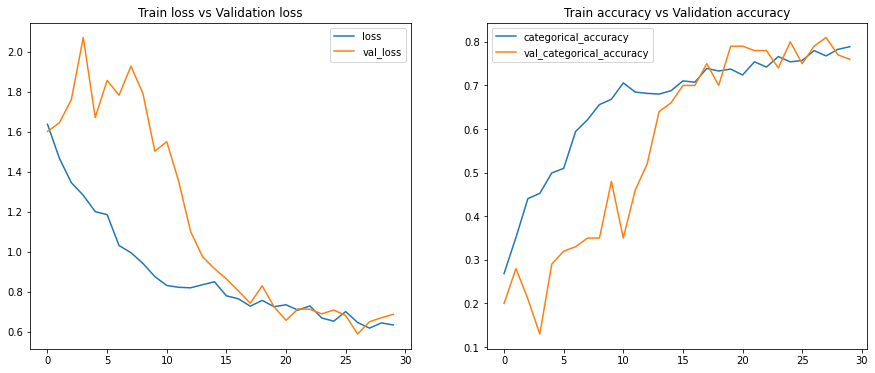

Max. Training Accuracy 0.7888386249542236
Max. Validaiton Accuracy 0.8100000023841858


In [ ]:
plotModelHistory(history_rnn_cnn2d_06_model)

Bets Model performance was observed with Batch size as 16 while sample size as 10 with Image resolution of 100x100. One last attempt was made with increased neurons in LSTM & Dense layers and 120x120 dimensions of the images fed to the model. The training and validation accuracies reached good enough number of 78% & 76 respectively. Although, this meant that higher size image is degrading the model performance.

|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 6 |LSTM |16 | 10 | 120x120 | 30 |    1, 656, 453 | .78 | .76 | 0.68 | Adam | Good fit

### Summary - LSTM Models  


|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 1 | LSTM|64 | 15 | 120x120 | 20 |    1, 656, 453 | .93 | .21 | 2.53| Adam | Overfit
| 2 | LSTM|32 | 15 | 120x120 | 30 |    1, 656, 453 | .96 | .32 | 2.21| Adam | Overfit
| 3 | LSTM|16 | 15 | 100x100 | 30 | 1, 656, 453 | .95 | .44 | 1.87 | Adam | Overfit
| 4 |LSTM |16 | 10 | 100x100 | 30 |    1, 009, 029 | .83 | .87 | .51 | Adam | Best Model
| 5 |LSTM |32 | 10 | 100x100 | 30 |    1, 004, 549 | .79 | .25 | 2.07 | Adam | Overfit
| 6 |LSTM |16 | 10 | 120x120 | 30 |    1, 656, 453 | .78 | .76 | 0.68 | Adam | Good fit

## GRU

In [ ]:
class RNN_CNN2D_GRU(ModelBuilder):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
        #model.add(TimeDistributed(BatchNormalization()))
        #model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam() #lr=0.001
        #optimiser = "sgd"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

### Model #1
- Batch Size = 64
- Num of Frames = 15
- Image Resolution = 120x120
- GRU Cells = 128
- Dense Layer = 128
- Dropout = 0.25

In [ ]:
gru_cnn2d_01=RNN_CNN2D_GRU()
gru_cnn2d_01.initialize_path(root_path)
gru_cnn2d_01.initialize_image(image_height=120,image_width=120)
gru_cnn2d_01.initialize_params(frames_to_sample=15,batch_size=64,num_epochs=30)
gru_cnn2d_01_model=gru_cnn2d_01.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
gru_cnn2d_01_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_128 (TimeDi (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_129 (TimeDi (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_130 (TimeDi (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_131 (TimeDi (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_132 (TimeDi (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_133 (TimeDi (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_134 (TimeDi (None, 15, 30, 30, 64)   

In [ ]:
history_gru_cnn2d_01_model=gru_cnn2d_01.train_model(gru_cnn2d_01_model,augment_data=False)

Epoch 1/30
11/11 [==============================] - 109s 10s/step - loss: 1.4265 - categorical_accuracy: 0.4103 - val_loss: 1.5500 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.55004, saving model to model_init_2021-10-2507_06_27.824826/model-00001-1.42647-0.41026-1.55004-0.23000.h5
Epoch 2/30
11/11 [==============================] - 100s 10s/step - loss: 0.9544 - categorical_accuracy: 0.6244 - val_loss: 1.8138 - val_categorical_accuracy: 0.1300

Epoch 00002: val_loss did not improve from 1.55004
Epoch 3/30
11/11 [==============================] - 95s 10s/step - loss: 0.7301 - categorical_accuracy: 0.7225 - val_loss: 2.0422 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.55004
Epoch 4/30
11/11 [==============================] - 101s 10s/step - loss: 0.5273 - categorical_accuracy: 0.8130 - val_loss: 2.2794 - val_categorical_accuracy: 0.2400

Epoch 00004: val_loss did not improve from 1.55004
Epoch 5/30
11/11 [==========

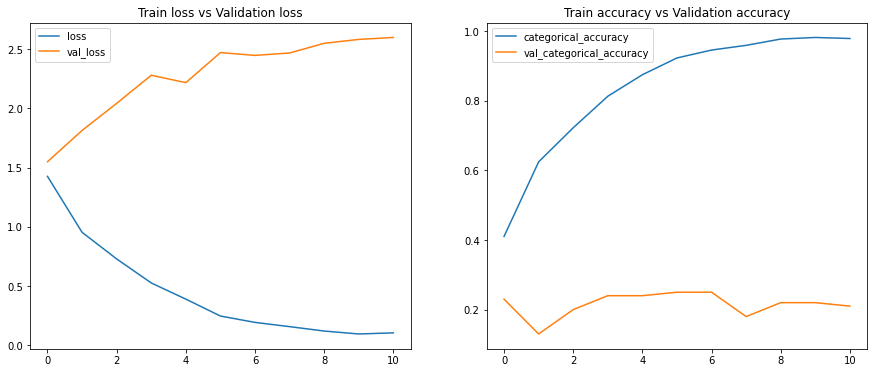

Max. Training Accuracy 0.9819004535675049
Max. Validaiton Accuracy 0.25


In [ ]:
plotModelHistory(history_gru_cnn2d_01_model)

As expected, A higher batch size and Image size of 120x120 also provided poor results with GRU version of RNN combined with CONV2D. 

The Training Accuracy and Loss was very good although the validation accuracy and loss were contrastingly very bad. 
Result is an Overfit model

|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 1 | GRU |64 | 15 | 120x120 | 20 |    1, 345, 413 | .97 | .21 | 2.59| Adam | Overfit

### Model #2
- Batch Size = 32
- Num of Frames = 15
- Image Resolution = 120x120
- GRU Cells = 128
- Dense Layer = 128
- Dropout = 0.25

In [ ]:
gru_cnn2d_02=RNN_CNN2D_GRU()
gru_cnn2d_02.initialize_path(root_path)
gru_cnn2d_02.initialize_image(image_height=120,image_width=120)
gru_cnn2d_02.initialize_params(frames_to_sample=15,batch_size=32,num_epochs=30)
gru_cnn2d_02_model=gru_cnn2d_02.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
gru_cnn2d_02_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 15, 30, 30, 64)   

In [ ]:
history_gru_cnn2d_02_model=gru_cnn2d_02.train_model(gru_cnn2d_02_model,augment_data=False)

Epoch 1/30
21/21 [==============================] - 6066s 302s/step - loss: 1.3464 - categorical_accuracy: 0.4329 - val_loss: 1.6538 - val_categorical_accuracy: 0.1700

Epoch 00001: val_loss improved from inf to 1.65378, saving model to model_init_2021-10-2508_30_21.778549/model-00001-1.34635-0.43288-1.65378-0.17000.h5
Epoch 2/30
21/21 [==============================] - 99s 5s/step - loss: 0.8961 - categorical_accuracy: 0.6637 - val_loss: 2.4163 - val_categorical_accuracy: 0.1700

Epoch 00002: val_loss did not improve from 1.65378
Epoch 3/30
21/21 [==============================] - 99s 5s/step - loss: 0.6637 - categorical_accuracy: 0.7496 - val_loss: 2.9697 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.65378
Epoch 4/30
21/21 [==============================] - 96s 5s/step - loss: 0.5164 - categorical_accuracy: 0.7964 - val_loss: 3.2367 - val_categorical_accuracy: 0.2100

Epoch 00004: val_loss did not improve from 1.65378
Epoch 5/30
21/21 [=============

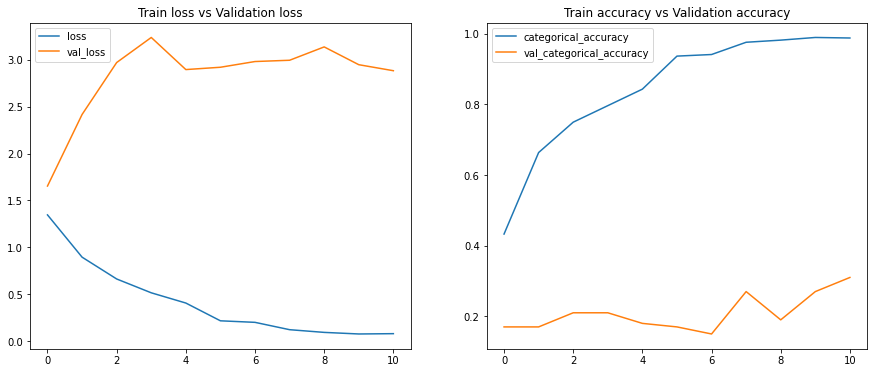

Max. Training Accuracy 0.9894419312477112
Max. Validaiton Accuracy 0.3100000023841858


In [ ]:
plotModelHistory(history_gru_cnn2d_02_model)

Model was run with Batch size of 32 while keeping all other parameters same as first model. 
The training accuracy improved but not significantly. Result is still an Overfit model

|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 2 | GRU |32 | 15 | 120x120 | 20 |    1, 345, 413 | .98 | .31 | 2.88| Adam | Overfit

### Model #3
- Batch Size = 16
- Num of Frames = 10
- Image Resolution = 100x100
- GRU Cells = 128
- Dense Layer = 128
- Dropout = 0.25

In [ ]:
gru_cnn2d_03=RNN_CNN2D_GRU()
gru_cnn2d_03.initialize_path(root_path)
gru_cnn2d_03.initialize_image(image_height=100,image_width=100)
gru_cnn2d_03.initialize_params(frames_to_sample=10,batch_size=16,num_epochs=30)
gru_cnn2d_03_model=gru_cnn2d_03.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
gru_cnn2d_03_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_48 (TimeDis (None, 10, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_49 (TimeDis (None, 10, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_50 (TimeDis (None, 10, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 10, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_52 (TimeDis (None, 10, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_53 (TimeDis (None, 10, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 10, 25, 25, 64)   

In [ ]:
history_gru_cnn2d_03_model=gru_cnn2d_03.train_model(gru_cnn2d_03_model,augment_data=False)

Epoch 1/30
42/42 [==============================] - 1578s 38s/step - loss: 1.3731 - categorical_accuracy: 0.4178 - val_loss: 2.1605 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 2.16054, saving model to model_init_2021-10-2704_27_08.201523/model-00001-1.37309-0.41780-2.16054-0.24000.h5
Epoch 2/30
42/42 [==============================] - 89s 2s/step - loss: 0.9885 - categorical_accuracy: 0.5867 - val_loss: 2.2788 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 2.16054
Epoch 3/30
42/42 [==============================] - 92s 2s/step - loss: 0.8217 - categorical_accuracy: 0.6938 - val_loss: 2.5197 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 2.16054
Epoch 4/30
42/42 [==============================] - 85s 2s/step - loss: 0.6199 - categorical_accuracy: 0.7798 - val_loss: 2.7424 - val_categorical_accuracy: 0.2100

Epoch 00004: val_loss did not improve from 2.16054
Epoch 5/30
42/42 [==============

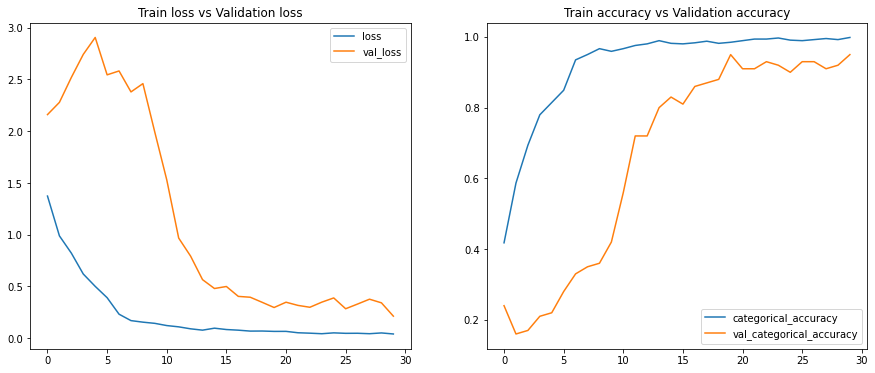

Max. Training Accuracy 0.9984917044639587
Max. Validaiton Accuracy 0.949999988079071


In [ ]:
plotModelHistory(history_gru_cnn2d_03_model)

Batch size was further reduced to 16, Number of frames used to 10 and Image resolution to 100x100. 
The model performance improved significantly. Training and Validation Accuracy reached 99% and 95% respectively. Validation loss was also under control 


|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 3 | GRU |16 | 10 | 100x100 | 20 |    1, 345, 413 | .99 | .95 | 0.44| Adam | Very Good fit

### Model #4

- Batch Size = 16
- Num of Frames = 10
- Image Resolution = 100x100
- GRU Cells = 64
- Dense Layer = 64
- Dropout = 0.5

In [ ]:
gru_cnn2d_04=RNN_CNN2D_GRU()
gru_cnn2d_04.initialize_path(root_path)
gru_cnn2d_04.initialize_image(image_height=100,image_width=100)
gru_cnn2d_04.initialize_params(frames_to_sample=10,batch_size=16,num_epochs=30)
gru_cnn2d_04_model=gru_cnn2d_04.define_model(gru_cells=64,dense_neurons=64,dropout=0.5)
gru_cnn2d_04_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_64 (TimeDis (None, 10, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_65 (TimeDis (None, 10, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_66 (TimeDis (None, 10, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_67 (TimeDis (None, 10, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_68 (TimeDis (None, 10, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_69 (TimeDis (None, 10, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_70 (TimeDis (None, 10, 25, 25, 64)   

In [ ]:
history_gru_cnn2d_04_model=gru_cnn2d_04.train_model(gru_cnn2d_04_model,augment_data=False)

Epoch 1/30
42/42 [==============================] - 62s 1s/step - loss: 1.7971 - categorical_accuracy: 0.2745 - val_loss: 2.0000 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 1.99999, saving model to model_init_2021-10-2511_51_57.358481/model-00001-1.79715-0.27451-1.99999-0.16000.h5
Epoch 2/30
42/42 [==============================] - 67s 2s/step - loss: 1.5422 - categorical_accuracy: 0.3469 - val_loss: 2.2414 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.99999
Epoch 3/30
42/42 [==============================] - 68s 2s/step - loss: 1.3972 - categorical_accuracy: 0.3922 - val_loss: 1.9275 - val_categorical_accuracy: 0.2600

Epoch 00003: val_loss improved from 1.99999 to 1.92750, saving model to model_init_2021-10-2511_51_57.358481/model-00003-1.39723-0.39216-1.92750-0.26000.h5
Epoch 4/30
42/42 [==============================] - 68s 2s/step - loss: 1.3987 - categorical_accuracy: 0.3680 - val_loss: 2.1791 - val_categorical

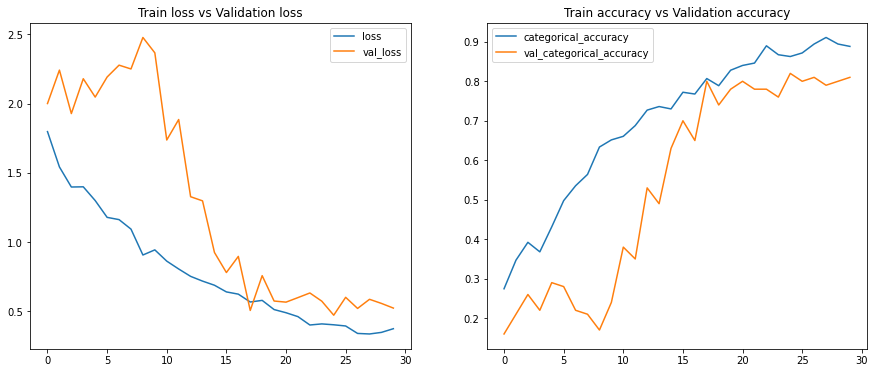

Max. Training Accuracy 0.9110105633735657
Max. Validaiton Accuracy 0.8199999928474426


In [ ]:
plotModelHistory(history_gru_cnn2d_04_model)

Model 3 was rerun with reduced trainable parameters by setting the GRU cells to 64 and Dense layer nuerons to 64. 

- The model perform well enough where Training and Validation Accuracy reached 88% and 81% respectively 
- Validation loss also reduced all the way through the training. 
- Result is a good enough fit model with generalizability

|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 4 | GRU |16 | 10 | 100x100 | 20 |    1, 345, 413 | .88 | .81 | 0.52| Adam | Good fit

## Transfer Learning

We will make use of the Transfer Learning by utilizing the MobileNet model and apply them on our best models each for LSTM and GRU 

### MobileNet with LSTM 

We will go with MobileNet model as it is lightweight in terms of architecture and therfore have high speed and performance as compared 
to other heavy-weight models like VGG16, Alexnet, InceptionV3 etc.

In [ ]:
from keras.applications import mobilenet

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_MOBILENET(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))        
        for layer in model.layers:
            layer.trainable = False     # Keeping the MobileNet weights 
                
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
               
        optimiser = tf.keras.optimizers.Adam() #lr=0.001
        #optimiser = "sgd"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
rnn_cnn_mobilenet_lstm=RNNCNN_MOBILENET()
rnn_cnn_mobilenet_lstm.initialize_path(root_path)
rnn_cnn_mobilenet_lstm.initialize_image(image_height=100,image_width=100)
rnn_cnn_mobilenet_lstm.initialize_params(frames_to_sample=10,batch_size=16,num_epochs=20)
rnn_cnn_mobilenet_lstm_model=rnn_cnn_mobilenet_lstm.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_mobilenet_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_84 (TimeDis (None, 10, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_85 (TimeDis (None, 10, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_86 (TimeDis (None, 10, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_87 (TimeDis (None, 10, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [ ]:
history_rnn_cnn_mobilenet_lstm_model=rnn_cnn_mobilenet_lstm.train_model(rnn_cnn_mobilenet_lstm_model,augment_data=False)

Epoch 1/20
42/42 [==============================] - 73s 2s/step - loss: 1.4107 - categorical_accuracy: 0.3967 - val_loss: 1.0338 - val_categorical_accuracy: 0.6700

Epoch 00001: val_loss improved from inf to 1.03383, saving model to model_init_2021-10-2512_55_37.997567/model-00001-1.41066-0.39668-1.03383-0.67000.h5
Epoch 2/20
42/42 [==============================] - 69s 2s/step - loss: 0.7498 - categorical_accuracy: 0.7466 - val_loss: 0.7121 - val_categorical_accuracy: 0.7400

Epoch 00002: val_loss improved from 1.03383 to 0.71214, saving model to model_init_2021-10-2512_55_37.997567/model-00002-0.74984-0.74661-0.71214-0.74000.h5
Epoch 3/20
42/42 [==============================] - 66s 2s/step - loss: 0.3830 - categorical_accuracy: 0.8733 - val_loss: 0.5973 - val_categorical_accuracy: 0.7400

Epoch 00003: val_loss improved from 0.71214 to 0.59727, saving model to model_init_2021-10-2512_55_37.997567/model-00003-0.38296-0.87330-0.59727-0.74000.h5
Epoch 4/20
42/42 [=======================

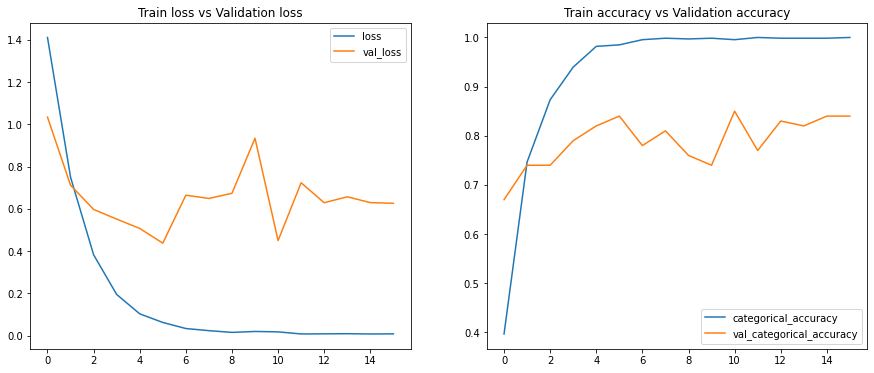

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.8500000238418579


In [ ]:
plotModelHistory(history_rnn_cnn_mobilenet_lstm_model)

We can see that MobileNet model added with LSTM and Dense layers picked up the Training Accuracy quickly and reach 100% while Validation accuracy still remained around 85%

The Validation loss also stagnated at higher levels than training and the model itself stopped after waiting for 10 epochs where validation loss does not come down its minimum value reached of .43 . The Model is a good fit but can be improved further

|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 1 | MobileNet-LSTM |16 | 10 | 100x100 | 20 |  609,541 | 1 | .84 | 0.62| Adam | Good fit

### MobileNet with GRU 

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_MOBILENET(ModelBuilder):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))        
        for layer in model.layers:
            layer.trainable = False     # Keeping the MobileNet weights 
                
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
               
        optimiser = tf.keras.optimizers.Adam() #lr=0.001
        #optimiser = "sgd"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_mobilenet_gru=RNNCNN_MOBILENET()
rnn_cnn_mobilenet_gru.initialize_path(root_path)
rnn_cnn_mobilenet_gru.initialize_image(image_height=100,image_width=100)
rnn_cnn_mobilenet_gru.initialize_params(frames_to_sample=10,batch_size=16,num_epochs=20)
rnn_cnn_mobilenet_gru_model=rnn_cnn_mobilenet_gru.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_mobilenet_gru_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_88 (TimeDis (None, 10, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_89 (TimeDis (None, 10, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_90 (TimeDis (None, 10, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_91 (TimeDis (None, 10, 1024)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)              

In [ ]:
history_rnn_cnn_mobilenet_gru_model=rnn_cnn_mobilenet_gru.train_model(rnn_cnn_mobilenet_gru_model,augment_data=False)

Epoch 1/20
42/42 [==============================] - 70s 2s/step - loss: 1.3480 - categorical_accuracy: 0.4299 - val_loss: 0.9398 - val_categorical_accuracy: 0.6900

Epoch 00001: val_loss improved from inf to 0.93979, saving model to model_init_2021-10-2513_51_09.672700/model-00001-1.34796-0.42986-0.93979-0.69000.h5
Epoch 2/20
42/42 [==============================] - 65s 2s/step - loss: 0.6285 - categorical_accuracy: 0.7934 - val_loss: 0.6793 - val_categorical_accuracy: 0.7600

Epoch 00002: val_loss improved from 0.93979 to 0.67928, saving model to model_init_2021-10-2513_51_09.672700/model-00002-0.62849-0.79336-0.67928-0.76000.h5
Epoch 3/20
42/42 [==============================] - 66s 2s/step - loss: 0.3142 - categorical_accuracy: 0.9065 - val_loss: 0.7172 - val_categorical_accuracy: 0.7400

Epoch 00003: val_loss did not improve from 0.67928
Epoch 4/20
42/42 [==============================] - 65s 2s/step - loss: 0.1754 - categorical_accuracy: 0.9472 - val_loss: 0.5841 - val_categorical

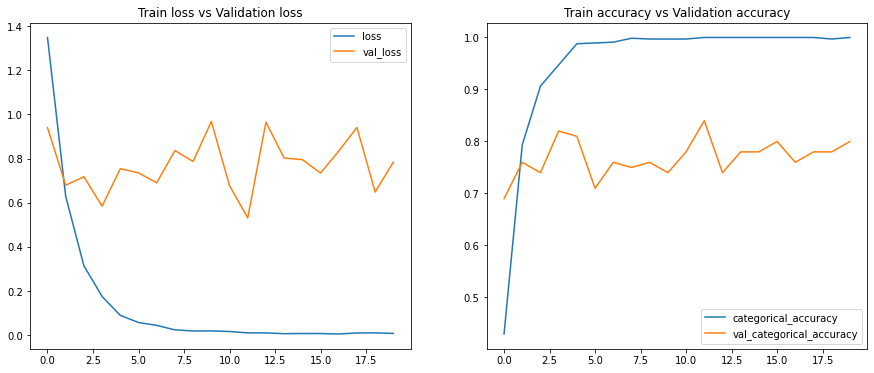

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.8399999737739563


In [ ]:
plotModelHistory(history_rnn_cnn_mobilenet_gru_model)

Next we tried MobileNet model with GRU, The model  picked up the Training Accuracy quickly and reach 100% while Validation accuracy still remained around 80%

The validation loss was low but did not quite catch up the training loss. Again though the Model is a good enough fit but can be improved further

|Model|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 2 | MobileNet-GRU |16 | 10 | 100x100 | 20 |  462,341 | 1 | .8 | 0.78| Adam | Good fit

## Write up - Summary

As per the problem statement, the requirement was to construct a deep learning models trained on a dataset of videos set of five categories of hand gestures, where each video is 30 image sequences. 

As mentioned, A Python Generator function was required to yield the batch data and batch labels when requested. We defined a master class called ModelBuilder()using Python's Abstract Base Class to define all basic routine steps in a single structure with the capability to tune the hyperparameters and vary the input. 

The ModelBuilder class contained the importing the dataset with correct path, setting the up properties of image sequence, initialisation of hyperparamters such as number of sequences to pick from a class and the generator function to yield the batch data and lables on request followed by method to train the model while apply some Keras callbacks for checkpointing and saving off the best model. The Generator function called inside the training also performed the image size reset to keep all images of same size and thereafter normalising them to same scale

First off, we tried Convolutional 3D networks to train the model on a sequence of images for a class with a temporal dimension. By performing some side experiments, it was observed that the model performance was affected by 4 main parameters namely 
1. Batch Size -> Number of inputs used by the model in feedforward before updating the weights 
2. Number of Frames -> Number of Images from a set of 30 are to be used by the model for training. 
3. Image Resolution -> The dimensions of the image did affected the model performance
4. Epoch -> Number of times the model is trained with entire pass on the training dataset. 

**CONV3D**

Based on above observations, Various combinations of above 4 paramertes were tried with CONV3D layers,BatchNormalisation, MaxPooling3D layers followed by dense layers and softmax output layer. 

9 different combinations were tried along with altering the CONV3D and dense layers on the data. The first 9 rows in the table describes the results obtained. We initially started to acheive overfit models with large batch size of 64 but as we reduced the batch size to 16 and increased the image sequence count to 20, we obtained model with high accuracies on training and validation set. Increase in the density of neurons in CONV3D layer and dense layers also improved the model performance as can be seen in the fifth model of type CONV3D below.

A replica of fifth model is retried as a final version with reduced trainable parameters, which although did not obtained as high accuracy as the original but was still a good with. 

Final model 

|Model#|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 9 |CONV3D |16 | 15 | 120x120 | 30 |    994, 853 | .82 | .88 |.69 |Adam | Good Fit/Reduced params

**Recurrent Neural Networks**

Another way to train 3D models is to use utilize the RNN models which are inherently build to deal with time series data such as a video. 

The ModelBuilder calls was used to construct RNN models of type LSTM and GRU. Initially input was fed to CONV2D layers for sampling with TimeDistributed layers followed by LSTM or GRU layers to take into account the inter-dependency of images in the sequence. 

- **LSTM** 


In case of LSTM, Overfit models were obtained with high batch size of 64 and 32 but when the batch size was reduced to 16 and number of frames to 10, we started obtaining good results of accuracies and loss on training and validation sets.
In this case, it was very clear that LSTM model gave good results when a low value of batch size and number of frames is used with a image size of 100x100.

Final model to be recommended with LSTM

|Model#|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 4 |LSTM |16 | 10 | 100x100 | 30 |    1, 009, 029 | .83 | .87 | .51 | Adam | Good fit


- **GRU**

On the similar lines to LSTM, GRU models also gave overfit models with high batch size. GRU model with cells size of 128 gave very excellent results. 
We trained the model with reduced trainable parameters with model architechure similar to LSTM and this also gave very optimal results where accuracies and loss values were comparable between the two algorithms
GRU should be preferred obviously as it has much less trainable parameters with same layer architecture, due to less number of gates inside the cells.

|Model#|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 4 |LSTM |16 | 10 | 100x100 | 30 |    1, 009, 029 | .83 | .87 | .51 | Adam | Good fit
| 4 | GRU |16 | 10 | 100x100 | 30 |    853, 125 | .88 | .81 | 0.52| Adam | Good fit

- **Transfer Learning**
MobileNet benchmark model was utilised given its lightweight architecture and high performance, compared to VGGNet, AlexNet etc,  to train with LSTM & GRU models to verify the results. 
The MobileNet models gave accuracy of 100% on training set and the loss was very close to 0 but the accuracy on validation set was somewhere around 80-85%. Since these were pre-trained models hence only 20 epochs were attempted. The model performance with transfer learning could be improved further as well.

|Model#|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 1 | MobileNet-LSTM |16 | 10 | 100x100 | 20 |  609,541 | 1 | .84 | 0.62| Adam | Good fit
| 2 | MobileNet-GRU |16 | 10 | 100x100 | 20 |  462,341 | 1 | .8 | 0.78| Adam | Good fit



- **Best Model**

The best model performance was obtained from a GRU based CNN+RNN network architecture with following settings. 

|Model#|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 3 | GRU |16 | 10 | 100x100 | 30 |    1, 345, 413 | .99 | .95 | 0.21| Adam | Very Good fit

Model = RNN_CNN2D_GRU
- image_height=100,image_width=100
- frames_to_sample=10
- batch_size=16,
- num_epochs=30
- GRU cells=128
- Dense neurons=128
- Dropout rate=0.25
- Trainable parameters=135,413

Performance 
- Training Accuracy=.99
- Validation Accuracy=.95
- Training Loss=0.04
- Validation Loss=.21

The h5 version of this model was saved off and is provided in the final submission.


## Final Summary of all the models

|Model#|Type |Batch Size|#Frames| ImageSize|Epochs|Tr Params|Tr Acc|Val Acc| Val Loss|Opt|Verdict
| --- | --- |--- |--- |--- |--- |--- |--- |---|---|---|--- |
| 1 |CONV3D|64 | 10 | 120x120 | 20 |    997, 157 | .99 | .22 |6.095| Adam | Overfit
| 2 |CONV3D|32 | 10 | 120x120 | 20 |    997, 157 | .95 | .29 | 5.77 |Adam | Overfit
| 3 |CONV3D|16 | 15 | 120x120 | 20 |    997, 157 | .95 | .88 | 0.51 |Adam | Good fit
| 4 |CONV3D|16 | 20 | 100x100 | 30 | 1, 255, 205 | .95 | .34 | 2.30 |Adam | Overfit
| 5 |CONV3D |16 | 20 | 120x120 | 30 | 7, 462, 357 | .96 | .89 | 1.337 |Adam | Good Fit/High Training time
| 6 |CONV3D |32 | 15 |   80x80 | 30 | 3, 615, 333 | .98 | .20 |9.43 | Adam | Worst Model
| 7 |CONV3D  |8 | 10 | 120x120 | 30 | 1, 931, 749 | .98 | .88 | .60 | SGD  | Very Good Fit
| 8 | CONV3D |8 | 10 | 120x120 | 30 |    994, 853 | .78 | .83 | .76|SGD  | Descent Fit
| 9 |CONV3D |16 | 15 | 120x120 | 30 |    994, 853 | .82 | .88 |.69 |Adam | Good Fit/Reduced params
| 1 | LSTM|64 | 15 | 120x120 | 20 |    1, 656, 453 | .93 | .21 | 2.53| Adam | Overfit
| 2 | LSTM|32 | 15 | 120x120 | 30 |    1, 656, 453 | .96 | .32 | 2.21| Adam | Overfit
| 3 | LSTM|16 | 15 | 100x100 | 30 | 1, 656, 453 | .95 | .44 | 1.87 | Adam | Overfit
| 4 |LSTM |16 | 10 | 100x100 | 30 |    1, 009, 029 | .83 | .87 | .51 | Adam | Good fit
| 5 |LSTM |32 | 10 | 100x100 | 30 |    1, 004, 549 | .79 | .25 | 2.07 | Adam | Overfit
| 6 |LSTM |16 | 10 | 120x120 | 30 |    1, 656, 453 | .78 | .76 | 0.68 | Adam | Good fit
| 1 | GRU |64 | 15 | 120x120 | 30 |    1, 345, 413 | .97 | .21 | 2.59| Adam | Overfit
| 2 | GRU |32 | 15 | 120x120 | 30 |    1, 345, 413 | .98 | .31 | 2.88| Adam | Overfit
| 3 | GRU |16 | 10 | 100x100 | 30 |    1, 345, 413 | .99 | .95 | 0.21| Adam | Best Model
| 4 | GRU |16 | 10 | 100x100 | 30 |    853, 125 | .88 | .81 | 0.52| Adam | Good fit/Reduced params
| 1 | MobileNet-LSTM |16 | 10 | 100x100 | 20 |  609,541 | 1 | .84 | 0.62| Adam | Good fit
| 2 | MobileNet-GRU |16 | 10 | 100x100 | 20 |  462,341 | 1 | .8 | 0.78| Adam | Good fit

Thanks

Abhishek Singh

aulakh.abhishek@gmail.com

+91 9990537789